In [1]:
import sys
sys.path.insert(1, './custom_modules')

In [2]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    image_shape = (256,256,160)
    channels = 1 
    train_batch_size = 4
    eval_batch_size = 4
    num_epochs = 80 #600 # one epoch needs ~12min (x2 GPU)
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100 #500
    evaluate_epochs = 20
    evaluate_num_batches = 20 # one batch needs ~15s.  
    evaluate_3D_epochs = 1000  # one 3D evaluation needs ~20min
    save_model_epochs = 60
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-lesions"  # the model name locally and on the HF Hub
    dataset_train_path = "./datasets/filling/dataset_train/imgs"
    segm_train_path = "./datasets/filling/dataset_train/segm"
    masks_train_path = "./datasets/filling/dataset_train/masks"
    dataset_eval_path = "./datasets/filling/dataset_eval/imgs"
    segm_eval_path = "./datasets/filling/dataset_eval/segm"
    masks_eval_path = "./datasets/filling/dataset_eval/masks" 
    train_only_connected_masks=True
    eval_only_connected_masks=False
    num_inference_steps=50
    mode = "train" # train / eval
    debug = True 

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    config.num_inference_steps=1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False
    config.evaluate_num_batches=1
    dataset_train_path = "./dataset_eval/imgs"
    segm_train_path = "./dataset_eval/segm"
    masks_train_path = "./dataset_eval/masks" 

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)
#if there are problems with ports then add manually "main_process_port: 0" or another number to yaml file

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
from DatasetMRI2D import DatasetMRI2D
from DatasetMRI3D import DatasetMRI3D
from pathlib import Path

#create dataset
datasetTrain = DatasetMRI2D(root_dir_img=Path(config.dataset_train_path), root_dir_segm=Path(config.segm_train_path), root_dir_masks=Path(config.masks_train_path), only_connected_masks=config.train_only_connected_masks)
datasetEvaluation = DatasetMRI2D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)
dataset3DEvaluation = DatasetMRI3D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Visualize dataset

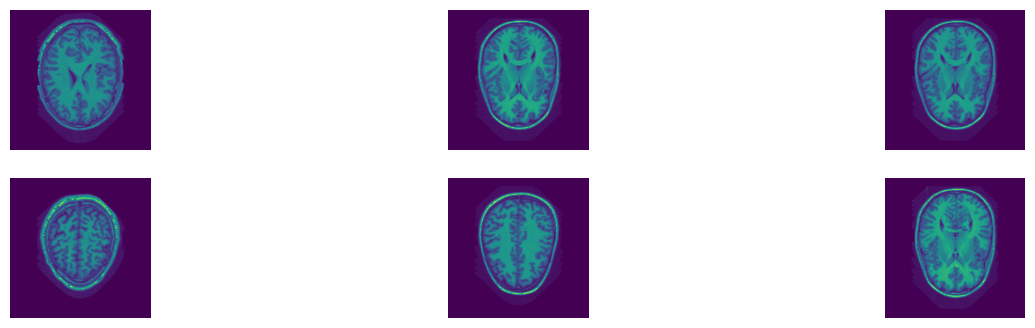

In [6]:
import matplotlib.pyplot as plt

# Get 6 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(6)) 

# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

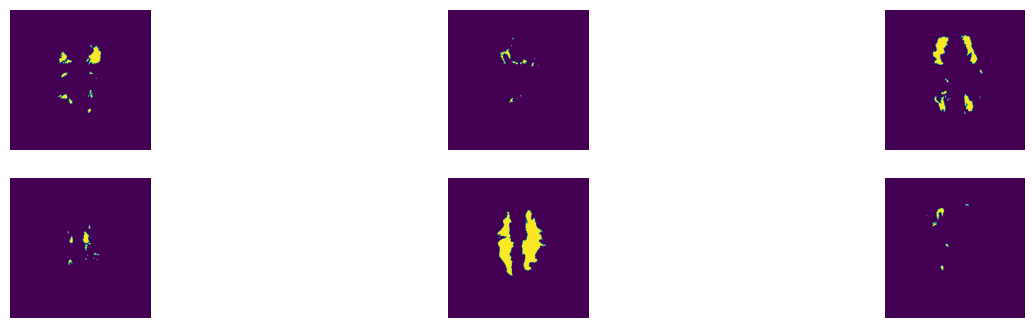

In [7]:
# Plot: masks
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(datasetTrain[idx]["mask"].squeeze())
    axis[i//3,i%3].set_axis_off()
fig.show()

### Prepare Training

In [8]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [9]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
#sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
#noise = torch.randn(sample_image.shape)
#timesteps = torch.LongTensor([50])
#noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [10]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

config.lr_scheduler = "cosine_schedule_with_warmup"

In [11]:
from TrainingConditional import TrainingConditional
from DDIMInpaintPipeline import DDIMInpaintPipeline
from Evaluation2DFilling import Evaluation2DFilling
from Evaluation3DFilling import Evaluation3DFilling 
import PipelineFactories

config.conditional_data = "Lesions"

args = {
    "config": config, 
    "model": model, 
    "noise_scheduler": noise_scheduler, 
    "optimizer": optimizer, 
    "lr_scheduler": lr_scheduler, 
    "datasetTrain": datasetTrain, 
    "datasetEvaluation": datasetEvaluation, 
    "dataset3DEvaluation": dataset3DEvaluation, 
    "trainingCircularMasks": False, 
    "evaluation2D": Evaluation2DFilling,
    "evaluation3D": Evaluation3DFilling, 
    "pipelineFactory": PipelineFactories.get_ddim_inpaint_pipeline}
trainingLesions = TrainingConditional(**args)

2024-04-05 08:43:50.878907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 08:43:52.466730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 08:43:52.466788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 08:43:52.473344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 08:43:53.420147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 08:43:53.426846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [ ]:
if config.mode == "train":
    trainingLesions.train()

  0%|          | 0/2047 [00:00<?, ?it/s]

In [ ]:
if config.mode == "eval":
    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) 
    trainingLesions.evaluate(pipeline)

In [ ]:
print("Finished Training")

In [ ]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_lesions.ipynb"
filename="lesion_filling_conditioned_lesions.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-18: 
            fp.write(line)
# Deactivate Debug!!!